## 1. Imports

### 1.1 Standard imports

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

### 1.2 NLP packages

In [2]:
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/maxencedubois/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxencedubois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Import NLP packages because they take a while to load so only import them when needed
from transformers import pipeline
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import nltk
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, TFAutoModelForSequenceClassification
import torch
import re

from scipy.special import softmax

# Topic Classification using BerTOPIC

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.3 Data import

In [42]:
# Import all the relevant files

path_to_data_folder = os.getcwd()  # This gets the current working directory

files = [f for f in os.listdir() if f.endswith('.xlsx')]


## 2. Data formatting

In [12]:
## bring each file into a DF
post_event = pd.read_excel(os.path.join(path_to_data_folder, files[0]), engine='openpyxl')
learning_connections = pd.read_excel(os.path.join(path_to_data_folder, files[2]), engine='openpyxl')
governance = pd.read_excel(os.path.join(path_to_data_folder, files[3]), engine='openpyxl')
pre_event = pd.read_excel(os.path.join(path_to_data_folder, files[5]), engine='openpyxl')

In [18]:
# Create a unique index for each row for when we unpivot and lengthen the data frame
post_event.index = post_event.index.map(lambda x: 'pst_{}'.format(x+1))
pre_event.index = pre_event.index.map(lambda x: 'pre_{}'.format(x+1))
learning_connections.index = learning_connections.index.map(lambda x: 'lc{}'.format(x+1))
governance.index = governance.index.map(lambda x: 'gov_{}'.format(x+1))

In [ ]:
# Isolate just the qualitatitve responses
post_event_qual = post_event[['answer_q1','answer_q2']]
pre_event_qual = pre_event[['answer_q1','answer_q2']]
learning_connections_qual = learning_connections[["'answer_q1','answer_q2'"]]
governance_qual = governance[["'answer_q1','answer_q2'"]]

In [20]:
# Rename the column that describes what role the respondent has so they are all consistent
for d in [post_event_qual, pre_event_qual, learning_connections_qual, governance_qual]:
    d.rename(columns = {d.columns[0]: "role"}, inplace=True)

In [21]:
# Unpivot the dataframes into long form for easier analysis
post_event_melt = pd.melt(post_event_qual, id_vars='role', ignore_index = False).dropna().reset_index()
pre_event_melt = pd.melt(pre_event_qual, id_vars='role', ignore_index = False).dropna().reset_index()
learning_connections_melt = pd.melt(learning_connections_qual, id_vars='role', ignore_index = False).dropna().reset_index()
governance_melt = pd.melt(governance_qual, id_vars='role', ignore_index = False).dropna().reset_index()

In [22]:
# Concatenate all the data into one long dataframe
all_qual = pd.concat([post_event_melt, pre_event_melt, learning_connections_melt, governance_melt], ignore_index=True)

In [ ]:
all_qual.head()

In [24]:
# Selecting relevant questions (open non-oriented questions)
open_neutral_questions = all_qual[all_qual['variable'].str.startswith(('Is there', 'Anything else'))]
open_neutral_questions.reset_index(drop=True, inplace=True)


In [25]:
# Splitting in sentences

def split_sentences(text):
    return nltk.sent_tokenize(text)


sentences = open_neutral_questions['value'].apply(split_sentences)

sentences_df = pd.DataFrame({
    'value': [sentence for sentences_per_row in sentences for sentence in sentences_per_row],
    **open_neutral_questions.drop('value', axis=1).loc[0].to_dict()
})

## 3. Sentiment analysis

### 3.1 Models

#### 3.1.1 SentimentIntensityAnalyser

In [26]:
### Conduct Sentiment analysis with NLTK

sia = SentimentIntensityAnalyzer()

def categorize_sentiment(sentence):
    score = sia.polarity_scores(sentence)['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# All questions

all_qual['sentiment_NLTK'] = all_qual['value'].apply(categorize_sentiment)

# Non-oriented sentences

sentences_df['sentiment_NLTK'] = sentences_df['value'].apply(categorize_sentiment)


#### 3.1.2 Bert 

In [27]:
# Conduct Sentiment analysis with BERT

model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")


# result.logits gives you a list of five values and argmax gives you the position of the highest value. the position in the
# list of the highest value represents the sentiment. So if the highest value was in position 0 this represents the most negative
# sentiment, ranging to position 4 which is the most positive.

def bert_sentiment(text):    
    if len(tokenizer.tokenize(text)) > 500:
        return "Text is too long"
    else:
        tokens = tokenizer.encode(text, return_tensors='pt')
        result = model(tokens)
        # I will convert the values to be 1-5 instead of 0-4 as its more intuitive
        sentiment = int(torch.argmax(result.logits)) + 1
        if sentiment == 1:
            text_sentiment = "Most_negative"
        elif sentiment == 2:
            text_sentiment = "Somewhat_negative"
        elif sentiment == 3:
            text_sentiment = "Neutral"
        elif sentiment == 4:
            text_sentiment = "Somewhat_positive"
        elif sentiment == 5:
            text_sentiment = "Most_positive"
        else:
            text_sentiment = 'NaN'
        return text_sentiment
    

In [28]:
# All questions

all_qual['sentiment_BERT'] = all_qual['value'].apply(bert_sentiment)


Token indices sequence length is longer than the specified maximum sequence length for this model (927 > 512). Running this sequence through the model will result in indexing errors


In [29]:
# Non-oriented questions

sentences_df['sentiment_BERT'] = sentences_df['value'].apply(bert_sentiment)

#### 3.1.3 Roberta

In [31]:
# Sentiment analysis using Roberta
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
def roberta_sentiment(text):   
    if len(tokenizer.tokenize(text)) > 500:
        return "Text is too long"
    else:
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        ranking = np.argsort(scores)
        ranking = ranking[::-1]    
        for i in range(scores.shape[0]):        
            l = config.id2label[ranking[i]]
            s = scores[ranking[i]]        
        label_index = np.argmax(scores)
        label = config.id2label[label_index]    
        return label




Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
all_qual['sentiment_robBERTa'] = all_qual['value'].apply(roberta_sentiment)

# Non-oriented questions

sentences_df['sentiment_robBERTa'] = sentences_df['value'].apply(roberta_sentiment)

In [ ]:
sentences_df

### 3.2 Model selection

#### 3.2.1 Test set (post-event data + learning connections)

In [34]:
# Randomly selecting 150 rows for human evaluation 

random_selection = sentences_df.sample(n=150, random_state=42)
random_selection.reset_index(drop=True, inplace=True)

# Saving as excel document to then do the evaluation
random_selection.to_excel('random_selection.xlsx', index=False)

In [44]:
# Importing the manually classified data
random_classified = pd.read_excel(os.path.join(path_to_data_folder, files[4]), engine='openpyxl')

In [38]:
# Replacing outcomes by numerical values

random_selection['sentiment_NLTK'] = random_selection['sentiment_NLTK'].replace({
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
})

random_selection['sentiment_BERT'] = random_selection['sentiment_BERT'].replace({
    'Most_positive': 1,
    'Somewhat_positive': 1,
    'Neutral': 0,
    'Somewhat_negative': -1,
    'Most_negative': -1,
})

random_selection['sentiment_robBERTa'] = random_selection['sentiment_robBERTa'].replace({
    'positive': 1,
    'neutral': 0,
    'negative': -1
})

In [57]:
random_selection['sentiment_AGGREGATED'] = np.where(random_selection['sentiment_NLTK'] + random_selection['sentiment_BERT'] + random_selection['sentiment_robBERTa']> 0, 1,
                            np.where(random_selection['sentiment_NLTK'] + random_selection['sentiment_BERT'] + random_selection['sentiment_robBERTa'] == 0, 0, -1))






    

#### 3.2.2 Models evaluation & selection

In [77]:
random_selection['Y_true'] = random_classified['Unnamed: 1']
y_test = random_selection['Y_true']
y_pred_NLTK = random_selection['sentiment_NLTK']
y_pred_BERT = random_selection['sentiment_BERT']
y_pred_robBERTa = random_selection['sentiment_robBERTa']
y_pred_AGG = random_selection['sentiment_AGGREGATED']

In [78]:
y_test.value_counts()

 1    69
-1    50
 0    31
Name: Y_true, dtype: int64

              precision    recall  f1-score   support

          -1       0.72      0.26      0.38        50
           0       0.30      0.26      0.28        31
           1       0.61      0.93      0.74        69

    accuracy                           0.57       150
   macro avg       0.54      0.48      0.46       150
weighted avg       0.58      0.57      0.52       150



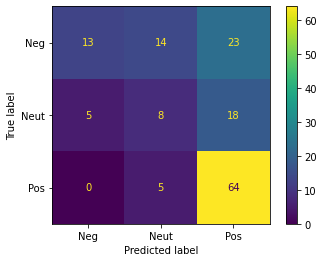

In [85]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score,     recall_score, roc_curve, auc, plot_confusion_matrix, explained_variance_score, f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics




print(classification_report(y_test,y_pred_NLTK))

confusion_matrix = metrics.confusion_matrix(y_test,y_pred_NLTK)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Neg', 'Neut','Pos'])
cm_display.plot()
plt.show()

              precision    recall  f1-score   support

          -1       0.69      0.44      0.54        50
           0       0.28      0.35      0.31        31
           1       0.85      0.96      0.90        69

    accuracy                           0.66       150
   macro avg       0.60      0.58      0.58       150
weighted avg       0.68      0.66      0.66       150



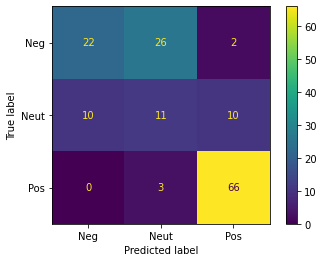

In [86]:
print(classification_report(y_test,y_pred_BERT))

confusion_matrix = metrics.confusion_matrix(y_test,y_pred_BERT)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Neg', 'Neut','Pos'])
cm_display.plot()
plt.show()

              precision    recall  f1-score   support

          -1       0.86      0.48      0.62        50
           0       0.54      0.71      0.61        31
           1       0.84      0.99      0.91        69

    accuracy                           0.76       150
   macro avg       0.74      0.73      0.71       150
weighted avg       0.78      0.76      0.75       150



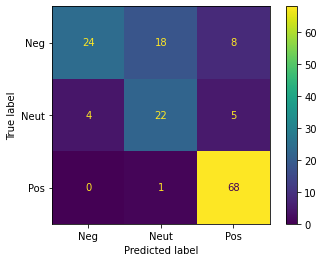

In [87]:
print(classification_report(y_test,y_pred_robBERTa))

confusion_matrix = metrics.confusion_matrix(y_test,y_pred_robBERTa)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Neg', 'Neut','Pos'])
cm_display.plot()
plt.show()

              precision    recall  f1-score   support

          -1       0.77      0.54      0.64        50
           0       0.38      0.16      0.23        31
           1       0.68      1.00      0.81        69

    accuracy                           0.67       150
   macro avg       0.61      0.57      0.56       150
weighted avg       0.65      0.67      0.63       150



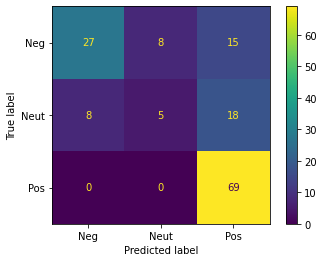

In [88]:
print(classification_report(y_test,y_pred_AGG))

confusion_matrix = metrics.confusion_matrix(y_test,y_pred_AGG)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Neg', 'Neut','Pos'])
cm_display.plot()
plt.show()

#### 3.2.3 Final results

**Looking at recall, precision and accuracy the robBERTA model clearly outperforms the other models, let us know have a look at the misclassified data** 

              precision    recall  f1-score   support

          -1       0.86      0.48      0.62        50
           0       0.54      0.71      0.61        31
           1       0.84      0.99      0.91        69

    accuracy                           0.76       150
   macro avg       0.74      0.73      0.71       150
weighted avg       0.78      0.76      0.75       150



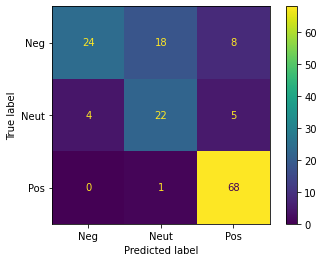

In [89]:
print(classification_report(y_test,y_pred_robBERTa))

confusion_matrix = metrics.confusion_matrix(y_test,y_pred_robBERTa)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Neg', 'Neut','Pos'])
cm_display.plot()
plt.show()

<ul>
    
<li>We observe that no truly positive comment is assessed as negative, one truly positive comment is assessed as neutral. </li>
    
    
<li>We observe that 8 truly negative sentences are classified as positive and 18 truly negative comments are classified as neutral (vs 1 pos as neutral) --> to investigate</li>
    
   
<li>We observe that a few neutral comments are missclassified (not a a major problem)</li>

</ul>

 



<ul>
    
**<li>We observe that many of those sentences include positive adjectives but with conditional --> The idea would be to reclassify the positive sentence that include conditional into negative sentiments</li>**
    
    
**<li>Let us try to reclassify sentence including "Could" and "Would and observe" the results)</li>**
    

</ul>

 

In [ ]:
# Closer look at negative answers classified as positive

for i in random_selection[(random_selection['Y_true'] == -1) & (random_selection['sentiment_robBERTa'] == 1)]['value']:
    print(i)
    print() 

In [ ]:
# Closer look at negative answers classified as neutral

for i in random_selection[(random_selection['Y_true'] == -1) & (random_selection['sentiment_robBERTa'] == 0)]['value']:
    print(i)
    print() 


<ul>
    
**<li>Again, changing would and could, would help improve the results </li>**
    
</ul>


In [136]:
# Lets create the "corrected robBERTA" model

random_selection['CORRECTED_sentiment_robBERTa'] = random_selection['sentiment_robBERTa'] 
random_selection['Neg_words'] = random_selection['value'].str.contains('would|could|Would|Could|hope|hoping').astype(int)
random_selection.loc[random_selection['Neg_words'] == 1, 'CORRECTED_sentiment_robBERTa'] = -1


              precision    recall  f1-score   support

          -1       0.78      0.76      0.77        50
           0       0.61      0.61      0.61        31
           1       0.91      0.93      0.92        69

    accuracy                           0.81       150
   macro avg       0.77      0.77      0.77       150
weighted avg       0.81      0.81      0.81       150



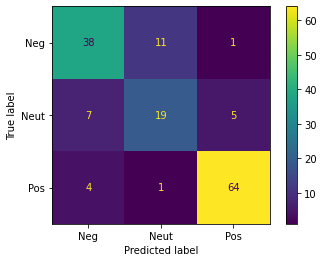

In [137]:
y_pred_Corr = random_selection['CORRECTED_sentiment_robBERTa']

print(classification_report(y_test,y_pred_Corr))

confusion_matrix = metrics.confusion_matrix(y_test,y_pred_Corr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Neg', 'Neut','Pos'])
cm_display.plot()
plt.show()


<ul>
    
**<li>Overral, this model performs better. Nevertheless, it is important to mention that some words containing the word "would" our "could" are related to positive sentences. </li>**
    
**<li> It is now time to do the correction on the 600 answers </li>**
    
    
</ul>


In [ ]:
# Closer look at positive answers classified as negative

for i in random_selection[(random_selection['Y_true'] == 1) & (random_selection['CORRECTED_sentiment_robBERTa'] == -1)]['value']:
    print(i)
    print() 


In [ ]:
# This step includes getting back to the original data (sentences_df), and correct the roBERTa results

final_sentences = sentences_df.drop(['sentiment_NLTK'],axis=1)
final_sentences.drop(['sentiment_BERT'],axis=1)

final_sentences['sentiment_robBERTa'] = final_sentences['sentiment_robBERTa'].replace({
    'positive': 1,
    'neutral': 0,
    'negative': -1
})


final_sentences['CORRECTED_sentiment_robBERTa'] = final_sentences['sentiment_robBERTa'] 
final_sentences['Neg_words'] = final_sentences['value'].str.contains('would|could|Would|Could|hope|hoping').astype(int)
final_sentences.loc[final_sentences['Neg_words'] == 1, 'CORRECTED_sentiment_robBERTa'] = -1
final_sentences = final_sentences.drop('Neg_words',axis=1)
final_sentences = final_sentences.drop('sentiment_robBERTa',axis=1)
final_sentences = final_sentences.drop('sentiment_BERT',axis=1)

final_sentences.head()

In [173]:
final_sentences.to_excel('final_data.xlsx', index=False)


In [175]:
final_sentences_short = final_sentences[~final_sentences['value'].apply(lambda x: len(str(x).split()) < 5 and any(word in str(x).lower() for word in ['thank', 'nil', 'no']))]

final_sentences_short.to_excel('final_sentences_short.xlsx', index=False)


In [ ]:
short_sentences = final_sentences[final_sentences['value'].apply(lambda x: len(str(x).split()) < 5)]

for i in short_sentences['value']:
    print(i)

## 3. Topic Modelling

In [151]:
# Topic Classification using BerTOPIC

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
# https://maartengr.github.io/BERTopic/index.html
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
topic_model = BERTopic(ctfidf_model=ctfidf_model, embedding_model="all-MiniLM-L6-v2")


In [19]:
# remove long responses as the model can't handle these
string_list = learning_connections_melt['value'][learning_connections_melt['variable'] == "Is there anything further you would like to share? (Optional)"].tolist()
for i, string in enumerate(string_list):
    if len(string) > 2000:
        string_list[i] = "RESPONSE TOO LONG"

In [22]:
# get topics for each question

topics, probs = topic_model.fit_transform(string_list)

topic_model.get_topic_info()

In [24]:
# Create a data frame with the identified topics and lists of words

data_list = []

for i in range(-1, topic_model.get_topic_info().shape[0]-1):    
    values = topic_model.get_topic(i)
    v_list = []
    for v in values:
        v_list.append(v[0])
    data_list.append({"Topic": i, "Theme_words":v_list})

data_list_df = pd.DataFrame(data_list)

In [25]:
# Find the number of responses associated with each topic
topic_counts = topic_model.get_topic_info()
topic_counts.drop("Name", axis =1, inplace=True)

In [26]:
# Create a dataframe with the topics and counts
data_list_df = data_list_df.merge(topic_counts, on="Topic")

In [27]:
# create a dataframe which groups each response by topic and shows what topic it is grouped against.
new_topic_df = pd.DataFrame({"Topic": topics, "value": learning_connections_melt['value'][learning_connections_melt['variable'] == "Is there anything further you would like to share? (Optional)"]})
new_topic_df = new_topic_df.merge(data_list_df, on='Topic')

In [28]:
# Save it all to an excel file

writer = pd.ExcelWriter("themes\learning_connections_Is there anything further you would like to share.xlsx")

data_list_df.to_excel(writer, sheet_name='Topics')
new_topic_df.to_excel(writer, sheet_name='Grouped_responses')

writer.save()

In [9]:
all_qual.to_excel('all_qual_responses.xlsx')